<a href="https://www.kaggle.com/code/leila413y/nlp-with-disaster-tweets-tf-idf-word2vec?scriptVersionId=237752876" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Natural Language Processing with Disaster Tweets

The goal of this project is to predict which tweets are about real disasters and which ones are not. Submissions are evaluated using F1 between the predicted and expected answers.

Here, I explore various methods for my own learning. I experiment with different embedding techniques, such as TF-IDF and Word2Vec, and apply models like Logistic Regression, GRU, and LSTM.

# 1 - Preliminaries

## Imports

In [1]:
import os
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing and embeddings
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import KeyedVectors

# ML model and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Deep learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, LSTM, Dense, Dropout
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# 2 - Exploratory Data Analysis

In [3]:
print(f"shape of train_df: {train_df.shape}")
print(f"shape of train_df: {test_df.shape}")

shape of train_df: (7613, 5)
shape of train_df: (3263, 4)


In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [7]:
train_df.describe(include='O')

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


In [8]:
test_df.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [9]:
test_df.describe(include='O')

,keyword,location,text
count,3237,2158,3263
unique,221,1602,3243
top,deluged,New York,11-Year-Old Boy Charged With Manslaughter of T...
freq,23,38,3


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


## Check for Missing Values

In [12]:
# missing values in train_df
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [13]:
# missing values in test_df
test_df.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [14]:
# percentage of missing values in train_df
train_df.isna().sum() / train_df.shape[0]

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [15]:
# percentage of missing values in test_df
test_df.isna().sum() / test_df.shape[0]

id          0.000000
keyword     0.007968
location    0.338645
text        0.000000
dtype: float64

## Target Distribution

In [16]:
train_df['target'].value_counts() / train_df.shape[0]

target
0    0.57034
1    0.42966
Name: count, dtype: float64

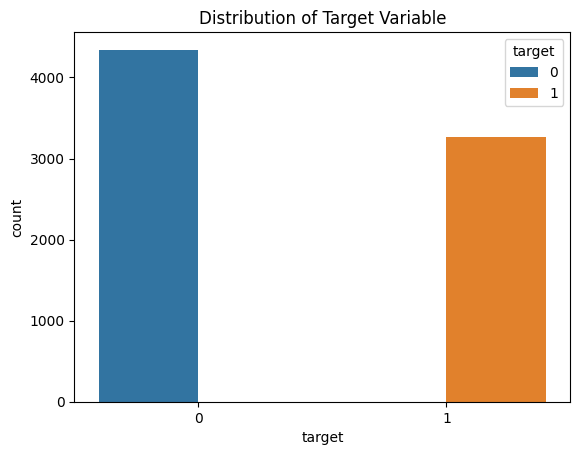

In [17]:
# Distribution of Target Variable
sns.countplot(data=train_df, x='target', hue='target')
plt.title('Distribution of Target Variable')
plt.show()

## Explore Features

### Feature 'location'

In [18]:
train_df['location'].nunique()

3341

In [19]:
test_df['location'].nunique()

1602

In [20]:
# Top 20 locations
locations_20 = train_df['location'].value_counts()[:20]
locations_20

location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
Everywhere          15
New York, NY        15
California, USA     15
Florida             14
Name: count, dtype: int64

In [21]:
# Top 20 Locations in Disasters tweets
locations_20_dis = train_df.loc[train_df['target']==1, 'location'].value_counts()[:20]
locations_20_dis

location
USA                 67
United States       27
Nigeria             22
India               20
Mumbai              19
UK                  16
London              16
New York            16
Washington, DC      15
Canada              13
Worldwide           12
Washington, D.C.     9
Chicago, IL          9
Australia            9
Indonesia            8
Los Angeles, CA      8
California, USA      8
Earth                8
California           7
New York, NY         7
Name: count, dtype: int64

In [22]:
# Top 20 Locations in Non-Disasters tweets
locations_20_non_dis = train_df.loc[train_df['target']==0, 'location'].value_counts()[:20]
locations_20_non_dis

location
New York           55
USA                37
London             29
United States      23
Los Angeles, CA    18
Canada             16
Kenya              15
Everywhere         12
Florida            11
UK                 11
California         10
NYC                10
United Kingdom     10
ss                  9
London, England     9
Australia           9
Chicago, IL         9
304                 9
San Francisco       8
New York, NY        8
Name: count, dtype: int64

### Feature 'keyword'

In [23]:
train_df['keyword'].nunique()

221

In [24]:
test_df['keyword'].nunique()

221

In [25]:
# Top 20 Keywords
keyword_train = train_df['keyword'].value_counts()
keyword_train[:20]

keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
Name: count, dtype: int64

In [26]:
# Top 20 Keywords in disaster tweets
keyword_dis = train_df.loc[train_df['target']==1, 'keyword'].value_counts()
keyword_dis[:20]

keyword
derailment               39
wreckage                 39
outbreak                 39
debris                   37
oil%20spill              37
typhoon                  37
evacuated                32
suicide%20bombing        32
rescuers                 32
suicide%20bomb           32
nuclear%20disaster       31
razed                    31
suicide%20bomber         30
earthquake               30
airplane%20accident      30
collision                29
wildfire                 29
bridge%20collapse        29
evacuation               28
buildings%20on%20fire    28
Name: count, dtype: int64

In [27]:
# Top 20 Keywords in non-disaster tweets
keyword_non_dis = train_df.loc[train_df['target']==0, 'keyword'].value_counts()
keyword_non_dis[:20]

keyword
body%20bags    40
harm           37
armageddon     37
wrecked        36
ruin           36
deluge         36
explode        35
twister        35
fear           35
siren          35
aftershock     34
panic          34
screaming      34
blizzard       33
blazing        33
blaze          33
crush          33
sinking        33
traumatised    33
curfew         32
Name: count, dtype: int64

### Length of Texts

In [28]:
train_df['text_len'] = train_df['text'].apply(len)

print(f"min length: {train_df['text_len'].min()}")
print(f"max length: {train_df['text_len'].max()}")
print(f"mean length: {train_df['text_len'].mean():.2f}")

min length: 7
max length: 157
mean length: 101.04


In [29]:
# average length of texts by the target
train_df.groupby('target')['text_len'].mean()

target
0     95.706817
1    108.113421
Name: text_len, dtype: float64

# 3 - Text Preprocessing

In [30]:
def clean_text(text):
    text = text.lower()                             # lowercase
    text = re.sub(r"http\S+|www.\S+", "", text)     # Remove URLs
    text = re.sub(r"@\S+", "", text)                # Remove @
    text = re.sub(r"#", "", text)                   # Remove hashtags
    text = re.sub(r"[^a-z\s]", "", text)            # Keep only letters and spaces
    text = text.strip()
    return text

train_df = train_df[['text', 'target']]
test_df = test_df[['text']]

train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

# 4 - Modeling

## 4.1 - Baseline Model (TF-IDF + Logistic Regression)

In [31]:
X = train_df['text']
y = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression model
model = LogisticRegression(max_iter=100, random_state=42)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

# 4.1 refers to the section number in this kernel
f1_scores = {}
f1_scores['4.1'] = round(f1_score(y_test, y_pred), 4)

In [32]:
f1_scores

{'4.1': 0.746}

We achieved a relatively high F1 score even with a simple baseline model, using TF-IDF and logistic regression.

Next, we will experiment with Word2Vec. I will first pre-train Word2Vec embeddings using the training data and later use pre-trained embedding vectors.

## 4.2 Semantic Embedding Model - Word2Vec

### 4.2.1 - Word2Vec (Training) (Keeping Stop Words) + Logistic Regression

We train Word2Vec embeddings here with different window sizes.

In [33]:
train_df['tokens'] = train_df['text'].apply(lambda x: word_tokenize(str(x)))

# Calculate avg. number of tokens
train_df['len'] = train_df['tokens'].apply(len)
print(f"avg. number of tokens: {train_df['len'].mean():.3}")

avg. number of tokens: 13.4


In [34]:
# Try different windows
emb_model = {}
window_range = [5, 10, 15, 20, 30]

for i in window_range:
    emb_model[i] = Word2Vec(train_df['tokens'], min_count=1, window=i, vector_size=100, seed=42)
    
# Function to convert tokens into Word2Vec embeddings
def tokens_to_vec(tokens, emb_model):
    vectors = [emb_model.wv[word] for word in tokens if word in emb_model.wv]
    if len(vectors)==0:
        return np.zeros(emb_model.vector_size)
    return np.mean(vectors, axis=0)

X, y = {}, {}
X_train, X_test = {}, {}
y_train, y_test = {}, {}

model = LogisticRegression(max_iter=100, random_state=42)

for i in window_range:
    # Convert tokens into vectors   
    X[i] = np.vstack(train_df['tokens'].apply(lambda tokens: tokens_to_vec(tokens, emb_model[i])))
    y[i] = train_df['target']
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X[i], y[i], test_size=0.2, random_state=42)
    
    model.fit(X_train[i], y_train[i])
    y_pred = model.predict(X_test[i])
    key = '4.2.1_' + str(i)
    f1_scores[key] = round(f1_score(y_test[i], y_pred), 4)

In [35]:
# Sort the scores by values
sorted_scores = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))
sorted_scores

{'4.1': 0.746,
 '4.2.1_15': 0.6176,
 '4.2.1_30': 0.6163,
 '4.2.1_20': 0.6099,
 '4.2.1_10': 0.6076,
 '4.2.1_5': 0.5778}

It yielded a low score. Next, we will remove stop words, though I expect the score will still be lower.

### 4.2.2 - Word2Vec (Training) (Removing Stop Words) + Logistic Regression

In [36]:
# Remove stop words
stop_words = set(stopwords.words('english'))
train_df['tokens'] = train_df['text'].apply(lambda x: [word for word in word_tokenize(str(x)) if word not in stop_words])

train_df['len'] = train_df['tokens'].apply(len)
print(f"avg. number of tokens AFTER removing stop words: {train_df['len'].mean():.3}")

avg. number of tokens AFTER removing stop words: 8.77


In [37]:
emb_model = {}

for i in window_range:
    emb_model[i] = Word2Vec(train_df['tokens'], min_count=1, window=i, vector_size=100, seed=42)

# Function to convert tokens into Word2Vec embeddings
def tokens_to_vec(tokens, emb_model):
    vectors = [emb_model.wv[word] for word in tokens if word in emb_model.wv]
    if len(vectors)==0:
        return np.zeros(emb_model.vector_size)
    return np.mean(vectors, axis=0)

X, y = {}, {}
X_train, X_test = {}, {}
y_train, y_test = {}, {}

model = LogisticRegression(max_iter=100, random_state=42)

for i in window_range:
    # Convert tokens into vectors   
    X[i] = np.vstack(train_df['tokens'].apply(lambda tokens: tokens_to_vec(tokens, emb_model[i])))
    y[i] = train_df['target']
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X[i], y[i], test_size=0.2, random_state=42)
    model.fit(X_train[i], y_train[i])
    y_pred = model.predict(X_test[i])
    key = '4.2.2_' + str(i)
    f1_scores[key] = round(f1_score(y_test[i], y_pred), 4)

In [38]:
# Sort the scores by values
sorted_scores = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))
sorted_scores

{'4.1': 0.746,
 '4.2.1_15': 0.6176,
 '4.2.1_30': 0.6163,
 '4.2.1_20': 0.6099,
 '4.2.1_10': 0.6076,
 '4.2.1_5': 0.5778,
 '4.2.2_30': 0.1198,
 '4.2.2_20': 0.1097,
 '4.2.2_15': 0.1092,
 '4.2.2_10': 0.0974,
 '4.2.2_5': 0.0471}

Removing stop words significantly decreased the score, possibly because tweets are short, and removing stop words changes their meaning considerably.

Next, I will try a deep learning model, GRU.

### 4.2.3 - Word2Vec (Training) (Keeping Stop Words) + GRU

In [39]:
# Convert text to integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
sequences = tokenizer.texts_to_sequences(train_df['text'])

# Maximun length of sequences
max_length = max([len(seq) for seq in sequences])

# Padded squences of integers (integer = word)
X = pad_sequences(sequences, maxlen=max_length)

train_df['tokens'] = train_df['text'].apply(lambda x: word_tokenize(str(x)))
emb_model = {}
for i in window_range:
    emb_model[i] = Word2Vec(train_df['tokens'], min_count=1, window=i, vector_size=100, seed=42)
    
# Create the embedding matrix
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = {i: np.zeros((vocab_size, embedding_dim)) for i in window_range}

for i in window_range:
    for word, idx in tokenizer.word_index.items():
        if word in emb_model[i].wv:
            embedding_matrix[i][idx] = emb_model[i].wv[word]

y = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the GRU model
model = {}
for i in window_range:
    weights = embedding_matrix[i]
    model[i] = Sequential([Embedding(input_dim=vocab_size,
                                    output_dim=embedding_dim,
                                    weights=[weights],
                                    input_length=max_length,
                                    trainable=False),
                            GRU(64, return_sequences=False),
                            Dropout(0.2),
                            Dense(1, activation='sigmoid')])
    model[i].compile(loss='binary_crossentropy', optimizer='adam', metrics=[BinaryAccuracy()])
    model[i].fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred = model[i].predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    key = '4.2.3_' + str(i)
    f1_scores[key] = round(f1_score(y_test, y_pred), 4)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [40]:
# Sort the scores by values
sorted_scores = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))
sorted_scores

{'4.1': 0.746,
 '4.2.3_30': 0.671,
 '4.2.3_20': 0.6575,
 '4.2.3_10': 0.6458,
 '4.2.3_15': 0.6438,
 '4.2.1_15': 0.6176,
 '4.2.1_30': 0.6163,
 '4.2.1_20': 0.6099,
 '4.2.1_10': 0.6076,
 '4.2.1_5': 0.5778,
 '4.2.3_5': 0.5411,
 '4.2.2_30': 0.1198,
 '4.2.2_20': 0.1097,
 '4.2.2_15': 0.1092,
 '4.2.2_10': 0.0974,
 '4.2.2_5': 0.0471}

The GRU model gives better scores than a logistic model, but it still scores lower than the baseline.

Next, I will try a LSTM model.

### 4.2.4 - Word2Vec (Training) (Keeping Stop Words) + LSTM

In [41]:
# Convert text to integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
sequences = tokenizer.texts_to_sequences(train_df['text'])

# Maximun length of sequences
max_length = max([len(seq) for seq in sequences])

# Padded squences of integers (integer = word)
X = pad_sequences(sequences, maxlen=max_length)

train_df['tokens'] = train_df['text'].apply(lambda x: word_tokenize(str(x)))

emb_model = {}
window_range = [5, 10, 15, 20, 30]

for i in window_range:
    emb_model[i] = Word2Vec(train_df['tokens'], min_count=1, window=i, vector_size=100, seed=42)


# Create the embedding matrix
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = {i: np.zeros((vocab_size, embedding_dim)) for i in window_range}

for i in window_range:
    for word, idx in tokenizer.word_index.items():
        if word in emb_model[i].wv:
            embedding_matrix[i][idx] = emb_model[i].wv[word]


y = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the LSTM model
model = {}
for i in window_range:
    weights = embedding_matrix[i]
    model[i] = Sequential([Embedding(input_dim=vocab_size,
                                        output_dim=embedding_dim,
                                        weights=[weights],
                                        input_length=max_length,
                                        trainable=False),
                                LSTM(64, return_sequences=False),
                                Dropout(0.2),
                                Dense(1, activation='sigmoid')])
    model[i].compile(loss='binary_crossentropy', optimizer='adam', metrics=[BinaryAccuracy()])
    model[i].fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred = model[i].predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    key = '4.2.4_' + str(i)
    f1_scores[key] = round(f1_score(y_test, y_pred), 4)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [42]:
# Sort the scores by values
sorted_scores = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))
sorted_scores

{'4.1': 0.746,
 '4.2.3_30': 0.671,
 '4.2.4_10': 0.6641,
 '4.2.4_30': 0.6623,
 '4.2.3_20': 0.6575,
 '4.2.4_20': 0.6524,
 '4.2.3_10': 0.6458,
 '4.2.3_15': 0.6438,
 '4.2.4_15': 0.6258,
 '4.2.1_15': 0.6176,
 '4.2.1_30': 0.6163,
 '4.2.1_20': 0.6099,
 '4.2.1_10': 0.6076,
 '4.2.1_5': 0.5778,
 '4.2.4_5': 0.564,
 '4.2.3_5': 0.5411,
 '4.2.2_30': 0.1198,
 '4.2.2_20': 0.1097,
 '4.2.2_15': 0.1092,
 '4.2.2_10': 0.0974,
 '4.2.2_5': 0.0471}

The LSTM model gave a slightly better result than the GRU model, but its score is still lower than the baseline.

### 4.2.5 - Word2Vec (Training) (Removing Stop Words) + LSTM

In [43]:
# Convert text to integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
sequences = tokenizer.texts_to_sequences(train_df['text'])

# Maximun length of sequences
max_length = max([len(seq) for seq in sequences])

# Padded squences of integers (integer = word)
X = pad_sequences(sequences, maxlen=max_length)

# Remove stop words
stop_words = set(stopwords.words('english'))
train_df['tokens'] = train_df['text'].apply(lambda x: [word for word in word_tokenize(str(x)) if word not in stop_words])

emb_model = {}
for i in window_range:
    emb_model[i] = Word2Vec(train_df['tokens'], min_count=1, window=i, vector_size=100, seed=42)

# Create the embedding matrix
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = {i: np.zeros((vocab_size, embedding_dim)) for i in window_range}

for i in window_range:
    for word, idx in tokenizer.word_index.items():
        if word in emb_model[i].wv:
            embedding_matrix[i][idx] = emb_model[i].wv[word]

y = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model = {}
for i in window_range:
    weights = embedding_matrix[i]
    model[i] = Sequential([Embedding(input_dim=vocab_size,
                                            output_dim=embedding_dim,
                                            weights=[weights],
                                            input_length=max_length,
                                            trainable=False),
                            LSTM(64, return_sequences=False),
                            Dropout(0.2),
                            Dense(1, activation='sigmoid')])
    model[i].compile(loss='binary_crossentropy', optimizer='adam', metrics=[BinaryAccuracy()])
    model[i].fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred = model[i].predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    key = '4.2.5_' + str(i)
    f1_scores[key] = round(f1_score(y_test, y_pred), 4)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [44]:
# Sort the scores by values
sorted_scores = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))
sorted_scores

{'4.1': 0.746,
 '4.2.3_30': 0.671,
 '4.2.4_10': 0.6641,
 '4.2.4_30': 0.6623,
 '4.2.3_20': 0.6575,
 '4.2.4_20': 0.6524,
 '4.2.3_10': 0.6458,
 '4.2.3_15': 0.6438,
 '4.2.4_15': 0.6258,
 '4.2.1_15': 0.6176,
 '4.2.1_30': 0.6163,
 '4.2.1_20': 0.6099,
 '4.2.1_10': 0.6076,
 '4.2.5_5': 0.6061,
 '4.2.1_5': 0.5778,
 '4.2.4_5': 0.564,
 '4.2.3_5': 0.5411,
 '4.2.5_15': 0.5152,
 '4.2.5_10': 0.5005,
 '4.2.5_20': 0.4525,
 '4.2.5_30': 0.4372,
 '4.2.2_30': 0.1198,
 '4.2.2_20': 0.1097,
 '4.2.2_15': 0.1092,
 '4.2.2_10': 0.0974,
 '4.2.2_5': 0.0471}

We observe once again that removing stop words leads to a decrease in the F1 score. But the LSTM model gives a significantly better result than the simple logistic regression when stop words being removed.

### 4.2.6 - Word2Vec (Pretrained) (No Finetuning) (Keeping Stop Words) + Logistic Regression

In [45]:
# Load Google's pre-trainined word vectors
word_vectors = KeyedVectors.load_word2vec_format('/kaggle/input/googlenews-vectors-negative300-bin-gz/GoogleNews-vectors-negative300.bin', binary=True)
train_df['tokens'] = train_df['text'].apply(lambda x: word_tokenize(str(x)))

# Function to convert tokens into Word2Vec embeddings
def tokens_to_vec(tokens, word_vectors):
    vectors = [word_vectors[word] for word in tokens if word in word_vectors]
    if len(vectors)==0:
        return np.zeros(300)
    return np.mean(vectors, axis=0)

X = np.vstack(train_df['tokens'].apply(lambda tokens: tokens_to_vec(tokens, word_vectors)))
y = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=100, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_scores['4.2.6'] = round(f1_score(y_test, y_pred), 4)

In [46]:
# Sort the scores by values
sorted_scores = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))
sorted_scores

{'4.2.6': 0.7477,
 '4.1': 0.746,
 '4.2.3_30': 0.671,
 '4.2.4_10': 0.6641,
 '4.2.4_30': 0.6623,
 '4.2.3_20': 0.6575,
 '4.2.4_20': 0.6524,
 '4.2.3_10': 0.6458,
 '4.2.3_15': 0.6438,
 '4.2.4_15': 0.6258,
 '4.2.1_15': 0.6176,
 '4.2.1_30': 0.6163,
 '4.2.1_20': 0.6099,
 '4.2.1_10': 0.6076,
 '4.2.5_5': 0.6061,
 '4.2.1_5': 0.5778,
 '4.2.4_5': 0.564,
 '4.2.3_5': 0.5411,
 '4.2.5_15': 0.5152,
 '4.2.5_10': 0.5005,
 '4.2.5_20': 0.4525,
 '4.2.5_30': 0.4372,
 '4.2.2_30': 0.1198,
 '4.2.2_20': 0.1097,
 '4.2.2_15': 0.1092,
 '4.2.2_10': 0.0974,
 '4.2.2_5': 0.0471}

Using a pretrained embedding yielded the score higher than the baseline for the first time although we used a very simple model, logistic regression. We see that pretrained embedding captures semantic relationships very effectively.

### 4.2.7 - Word2Vec (Pretrained) (No Finetuning) (Keeping Stop Words) + LSTM

In [47]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
sequences = tokenizer.texts_to_sequences(train_df['text'])

# Maximum sequence length
max_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_length)

# Create the embedding matrix
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[idx] = word_vectors[word]

y = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential([Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=False),
                    LSTM(64, return_sequences=False),
                    Dropout(0.2),
                    Dense(1, activation='sigmoid')])

# Compile and train the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[BinaryAccuracy()])
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Compute F1-score
f1_scores['4.2.7'] = round(f1_score(y_test, y_pred), 4)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [48]:
# Sort the scores by values
sorted_scores = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))
sorted_scores

{'4.2.7': 0.7616,
 '4.2.6': 0.7477,
 '4.1': 0.746,
 '4.2.3_30': 0.671,
 '4.2.4_10': 0.6641,
 '4.2.4_30': 0.6623,
 '4.2.3_20': 0.6575,
 '4.2.4_20': 0.6524,
 '4.2.3_10': 0.6458,
 '4.2.3_15': 0.6438,
 '4.2.4_15': 0.6258,
 '4.2.1_15': 0.6176,
 '4.2.1_30': 0.6163,
 '4.2.1_20': 0.6099,
 '4.2.1_10': 0.6076,
 '4.2.5_5': 0.6061,
 '4.2.1_5': 0.5778,
 '4.2.4_5': 0.564,
 '4.2.3_5': 0.5411,
 '4.2.5_15': 0.5152,
 '4.2.5_10': 0.5005,
 '4.2.5_20': 0.4525,
 '4.2.5_30': 0.4372,
 '4.2.2_30': 0.1198,
 '4.2.2_20': 0.1097,
 '4.2.2_15': 0.1092,
 '4.2.2_10': 0.0974,
 '4.2.2_5': 0.0471}

Once again, using pre-trained embedding vectors gives a good result close to the baseline.

### 4.2.8 - Word2Vec (Pretrained) (Finetuning) (Keeping Stop Words) + LSTM

In [49]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
sequences = tokenizer.texts_to_sequences(train_df['text'])

# Maximum sequence length
max_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_length)

# Create the embedding matrix
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[idx] = word_vectors[word]

y = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential([Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=True),
                    LSTM(64, return_sequences=False),
                    Dropout(0.2),
                    Dense(1, activation='sigmoid')])

# Compile and train the model
optimizer = Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[BinaryAccuracy()])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Compute F1-score
f1_scores['4.2.8'] = round(f1_score(y_test, y_pred), 4)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [50]:
# Sort the scores by values
sorted_scores = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))
sorted_scores

{'4.2.8': 0.782,
 '4.2.7': 0.7616,
 '4.2.6': 0.7477,
 '4.1': 0.746,
 '4.2.3_30': 0.671,
 '4.2.4_10': 0.6641,
 '4.2.4_30': 0.6623,
 '4.2.3_20': 0.6575,
 '4.2.4_20': 0.6524,
 '4.2.3_10': 0.6458,
 '4.2.3_15': 0.6438,
 '4.2.4_15': 0.6258,
 '4.2.1_15': 0.6176,
 '4.2.1_30': 0.6163,
 '4.2.1_20': 0.6099,
 '4.2.1_10': 0.6076,
 '4.2.5_5': 0.6061,
 '4.2.1_5': 0.5778,
 '4.2.4_5': 0.564,
 '4.2.3_5': 0.5411,
 '4.2.5_15': 0.5152,
 '4.2.5_10': 0.5005,
 '4.2.5_20': 0.4525,
 '4.2.5_30': 0.4372,
 '4.2.2_30': 0.1198,
 '4.2.2_20': 0.1097,
 '4.2.2_15': 0.1092,
 '4.2.2_10': 0.0974,
 '4.2.2_5': 0.0471}

It gave the best result so far. I am curious to see how removing stop words will impact the score, so let's give it a try.

### 4.2.9 - Word2Vec (Pretrained) (Finetuning) (Removing Stop Words) + LSTM

In [51]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

train_df['text'] = train_df['text'].apply(remove_stopwords)

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
sequences = tokenizer.texts_to_sequences(train_df['text'])

# Maximum sequence length
max_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_length)

# Create the embedding matrix
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[idx] = word_vectors[word]

y = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential([Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=True),
                    LSTM(64, return_sequences=False),
                    Dropout(0.2),
                    Dense(1, activation='sigmoid')])

# Compile and train the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[BinaryAccuracy()])
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Compute F1-score
f1_scores['4.2.9'] = round(f1_score(y_test, y_pred), 4)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [52]:
# Sort the scores by values
sorted_scores = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))
sorted_scores

{'4.2.8': 0.782,
 '4.2.7': 0.7616,
 '4.2.6': 0.7477,
 '4.1': 0.746,
 '4.2.9': 0.701,
 '4.2.3_30': 0.671,
 '4.2.4_10': 0.6641,
 '4.2.4_30': 0.6623,
 '4.2.3_20': 0.6575,
 '4.2.4_20': 0.6524,
 '4.2.3_10': 0.6458,
 '4.2.3_15': 0.6438,
 '4.2.4_15': 0.6258,
 '4.2.1_15': 0.6176,
 '4.2.1_30': 0.6163,
 '4.2.1_20': 0.6099,
 '4.2.1_10': 0.6076,
 '4.2.5_5': 0.6061,
 '4.2.1_5': 0.5778,
 '4.2.4_5': 0.564,
 '4.2.3_5': 0.5411,
 '4.2.5_15': 0.5152,
 '4.2.5_10': 0.5005,
 '4.2.5_20': 0.4525,
 '4.2.5_30': 0.4372,
 '4.2.2_30': 0.1198,
 '4.2.2_20': 0.1097,
 '4.2.2_15': 0.1092,
 '4.2.2_10': 0.0974,
 '4.2.2_5': 0.0471}

Removing stop words slightly decreased the score, but it's still relatively high due to the pre-trained word embeddings.

We have explored various embedding methods and models, and observed how pre-trained embeddings play an important role. Surprisingly, a simple baseline model also yields a relatively good result.

While hyperparameter tuning could further improve the score, I have achieved my goal of trying various methods, so I will conclude here.

For the submission, I have chosen the pre-trained Word2Vec with LSTM model and scored 0.79221.

*(updated on 2025/03/21)*